# Setup

In [13]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
import scipy
from scipy.stats import norm

In [7]:
input_folder = '\\\\filenest.diskstation.me\\Wilbrecht_file_server\\Madeline\\processed_data'
input_file = 'JUV011\\211215\\JUV011-211215-gonogo-001.hdf5'

In [18]:
hfile = os.path.join(input_folder, input_file)
hf = h5py.File(hfile, 'r')
hf.keys()

<KeysViewHDF5 ['dff', 'dims', 'dview', 'estimates', 'mmap_file', 'params', 'remove_very_bad_comps', 'skip_refinement', 'snr']>

# Spatial Components ('A' matrix)

In [93]:
# A is stored as a scipy.sparse.csc_matrix
def load_A(hf):
    if 'estimates' in hf:
        A = hf['estimates']['A']
    else:
        A = hf['Nsparse']
    data = A['data']
    indices = A['indices']
    indptr = A['indptr']
    return csc_matrix((data, indices, indptr), A['shape'])


A = load_A(hf)
A.shape

(44944, 161)

In [89]:
dims = np.array(hf['dims'])
dims.tolist()

[212, 212]

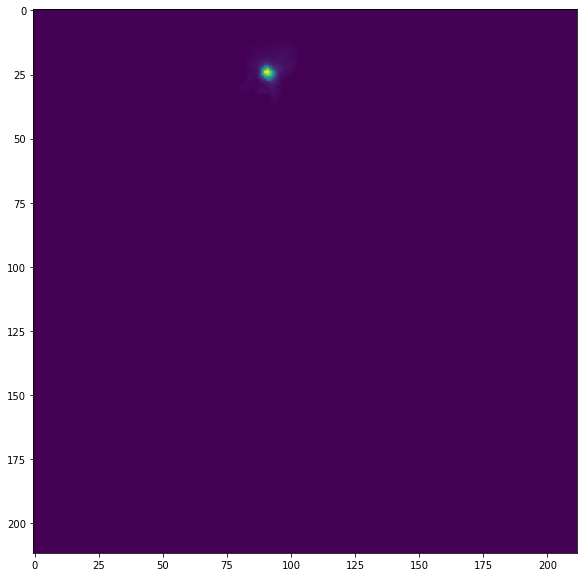

In [150]:
roi_index = 157
plt.figure(figsize=(10, 10))
plt.imshow(A.toarray()[:, roi_index].reshape(dims, order='F'))

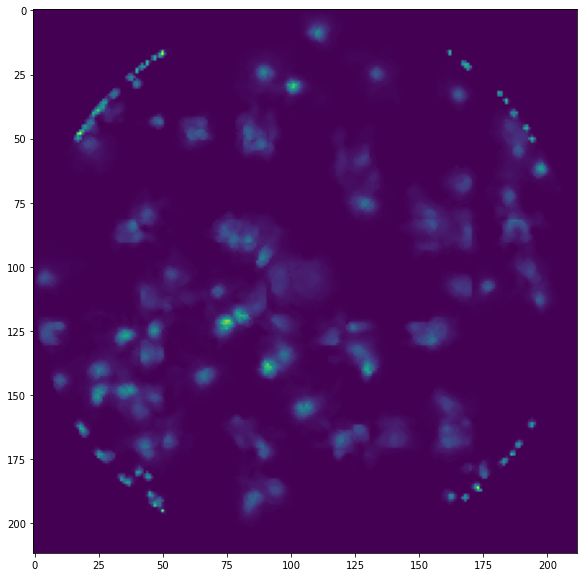

In [151]:
roi_aggregate = np.sum(A, axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(roi_aggregate.reshape(dims, order='F'))

### Filter ROIs using SNR

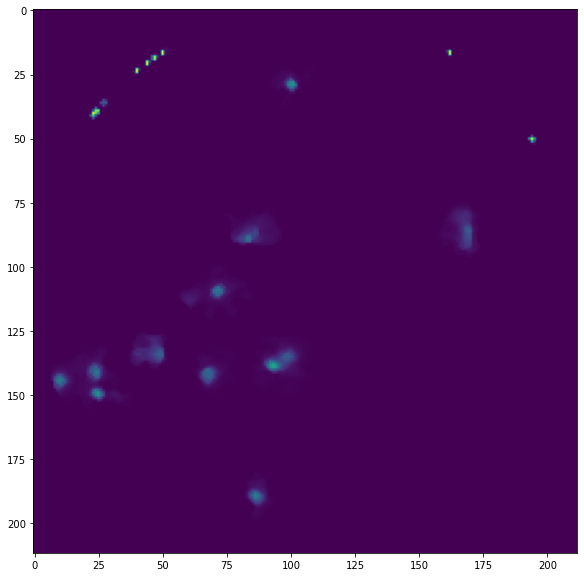

In [101]:
# will only add ROI's with SNR greater than this value
snr_cutoff = 7
n_rois = A.shape[1]
roi_filter_aggregate = np.zeros(shape=(A.shape[0], 1))
np.array(hf['snr'])
for i in range(n_rois):
    if hf['snr'][i] > snr_cutoff:
        roi_filter_aggregate += A[:, i]
plt.figure(figsize=(10, 10))
plt.imshow(roi_filter_aggregate.reshape(dims, order='F'))

# Temporal Components ('C' Matrix)

In [49]:
C = np.array(hf['estimates/C'])
C.shape

(161, 36000)

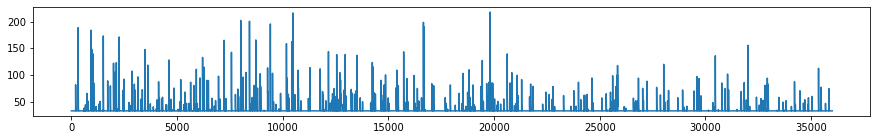

In [154]:
roi_index = 157
plt.figure(figsize=(15, 2))
plt.plot(C[roi_index])

### Find 'n' most active ROI's

In [111]:
n = 5
np.argpartition(np.std(C, axis=1), -n)[-n:].tolist()

[154, 100, 56, 99, 102]